In [30]:
import pandas as pd
import numpy as np
from model_utils.model import EmotionCNN
import cv2
import torch
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as F
from deepface import DeepFace
import mediapipe as mp
import os
from matplotlib import pyplot as plt

## Variables

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_type = "EmotionCNN"
emotion_labels = ["Angry", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad",
                  "Surprise"] if model_type == "EmotionCNN" else ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"]


df = pd.read_csv("datasets/df.csv")
measures_features = ["mouth_opening", "left_eye_opening",
                     "right_eye_opening", "smile_width"]
emotions_features = ["anger", "contempt", "disgust",
                     "fear", "joy", "neutral", "sadness", "surprise"]
data_measures = df[measures_features].to_numpy()
data_emotions = df[emotions_features].to_numpy()

vector_measures = np.array([10, 9, 9, 40])
vector_emotions = np.array([0.125]*8)

face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


trained_model = EmotionCNN().to(device)
trained_model.load_state_dict(torch.load(
    'models/emotion_all_cnn3.pth', map_location=device, weights_only=True))
trained_model.eval()

image_to_index = {
    "j1": 0, "j2": 1, "n1": 2, "n2": 3, "s1": 5, "s2": 6,
    "a1": 7, "a2": 8, "d1": 11, "d2": 12, "su1": 13, "su2": 14
}
image_folder = "datasets/df_metric"

EmotionCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1,

## Functions

In [37]:
def compute_distance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

def analyze_face_landmarks(image, landmarks):
    MOUTH_POINTS = [13, 14, 78, 308]
    EYE_POINTS = {
        "left": [145, 159],
        "right": [374, 386]
    }

    h, w, _ = image.shape
    results = {}

    coords = [(int(landmark.x * w), int(landmark.y * h))
              for landmark in landmarks.landmark]

    mouth_opening = compute_distance(
        coords[MOUTH_POINTS[0]], coords[MOUTH_POINTS[1]])
    results["mouth_opening"] = mouth_opening

    left_eye_opening = compute_distance(
        coords[EYE_POINTS["left"][0]], coords[EYE_POINTS["left"][1]])
    right_eye_opening = compute_distance(
        coords[EYE_POINTS["right"][0]], coords[EYE_POINTS["right"][1]])
    results["eye_opening"] = {
        "left": left_eye_opening, "right": right_eye_opening}

    smile_width = compute_distance(
        coords[MOUTH_POINTS[2]], coords[MOUTH_POINTS[3]])
    results["smile_width"] = smile_width

    return results


mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(refine_landmarks=True, max_num_faces=1)


def get_vector_measures(frame):
    if len(frame.shape) == 2:
        frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
    result = face_mesh.process(frame)
    vector_measure = [10, 9, 9, 40]

    if result.multi_face_landmarks:
        face_landmarks = result.multi_face_landmarks[0]
        analysis = analyze_face_landmarks(frame, face_landmarks)
        vector_measure = [analysis['mouth_opening'], analysis['eye_opening']['left'],
                          analysis['eye_opening']['right'], analysis['smile_width']]

    return vector_measure

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

def predict_emotion(face_roi):
    """Predicts emotion based on the selected model."""
        # Process face ROI for EmotionCNN model
    face_img = Image.fromarray(face_roi).convert('L')
    face_tensor = transform(face_img).unsqueeze(0).to(device)
    with torch.no_grad():

        output = trained_model(face_tensor)
        probabilities = F.softmax(output, dim=1)

    return probabilities.squeeze(0).numpy()




## Evaluation

In [ ]:
def evaluate_image(image, alpha_emotions):
    # Get the vector of emotions and measures
    vector_emotions = predict_emotion(image)
    vector_measures = get_vector_measures(image)
    
    # Compute the distances
    distances_measures = np.linalg.norm(
        data_measures - vector_measures, axis=1)
    distances_emotions = np.linalg.norm(
        data_emotions - vector_emotions, axis=1)
    
    # Deduce the probabilities
    # proba_measures = np.exp(distances_measures) / \
    #     np.sum(np.exp(distances_measures))
    # proba_emotions = np.exp(distances_emotions) / \
    #     np.sum(np.exp(distances_emotions))
    proba_measures = distances_measures / np.sum(distances_measures)
    proba_emotions = distances_emotions / np.sum(distances_emotions)
    
    # Combine the probabilities
    proba_final = alpha_emotions * proba_emotions + \
        (1 - alpha_emotions) * proba_measures
        
    idx = np.argmin(proba_final)
    return idx

In [35]:
def evaluate_method(alpha_emotions):
    total_images = 0
    correct_predictions = 0
    for filename in os.listdir(image_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            image_key = filename[:2]
            if image_key in image_to_index:
                expected_index = image_to_index[image_key]

                image_path = os.path.join(image_folder, filename)
                image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

                predicted_index = evaluate_image(image, alpha_emotions)

                if predicted_index == expected_index:
                    correct_predictions += 1
                total_images += 1

    accuracy = correct_predictions / total_images if total_images > 0 else 0

    return accuracy

Alpha: 0.0 -> Accuracy: 0.1031
Alpha: 0.2 -> Accuracy: 0.1031
Alpha: 0.4 -> Accuracy: 0.1031
Alpha: 0.6 -> Accuracy: 0.1031
Alpha: 0.8 -> Accuracy: 0.1031
Alpha: 1.0 -> Accuracy: 0.0


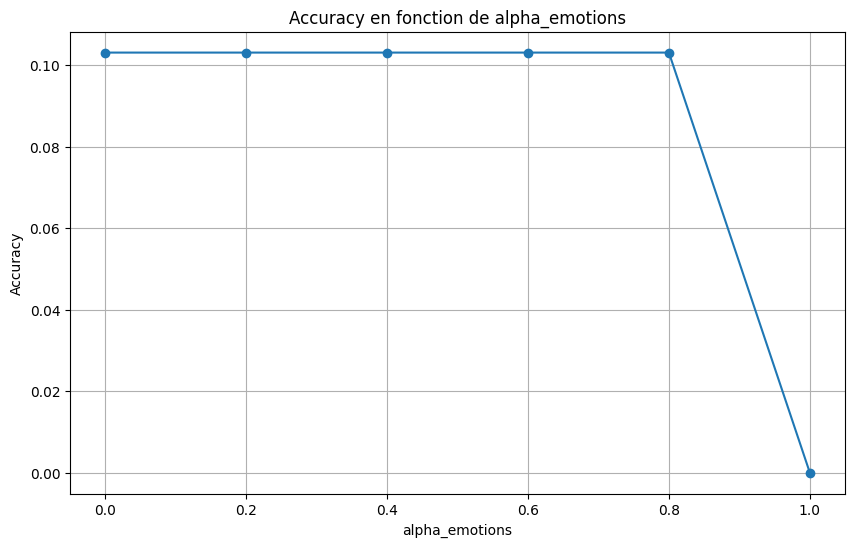

In [39]:
def plot_accuracy(step = 0.2):
    alphas = np.arange(0, 1.05, step) 
    accuracies = []

    for alpha in alphas:
        accuracy = evaluate_method(alpha)
        print(f"Alpha: {round(alpha,4)} -> Accuracy: {round(accuracy, 4)}")
        accuracies.append(accuracy)

    plt.figure(figsize=(10, 6))
    plt.plot(alphas, accuracies, marker='o')
    plt.title("Accuracy en fonction de alpha_emotions")
    plt.xlabel("alpha_emotions")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.show()


plot_accuracy()